# Сборный проект —2.

# Описание проекта.

Компания «Работа с заботой» предоставила нам данные с характеристиками сотрудников компании. HR-аналитики данной компании помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.<br><br>**Первая задача**, которую нам необходимо выполнить — это построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.<br>В нашем распоряжении будут следующие файлы:<br>- train_job_satisfaction_rate.csv (тренировочная выборка);<br>- test_features.csv (входные признаки тестовой выборки);<br>- test_target_job_satisfaction_rate.csv (целевой признак тестовой выборки).<br><br>**Вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.<br>Тут нам предоставили также три файла:<br>- train_quit.csv (тренировочная выборка);<br>- test_features.csv (входные признаки тестовой выборки те же, что и в прошлой задаче);<br>- test_target_quit.csv (целевой признак тестовой выборки).<br><br>После выполнения задач необходимо сделать определенные выводы и приложить к ним предложения для бизнеса.

# Задача 1.

# Загрузка данных.

In [1]:
! pip install shap -q

In [2]:
! pip install phik

In [3]:
!pip install -U scikit-learn

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   LabelEncoder, 
                                   LabelBinarizer)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.svm import SVC
from phik.report import plot_correlation_matrix
from phik import report
from scipy.stats import randint

In [5]:
df_train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

In [6]:
df_train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
df_train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
df_test_features = pd.read_csv('/datasets/test_features.csv')

In [9]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [11]:
df_test_target_job = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [12]:
df_test_target_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [13]:
df_test_target_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Промежуточный вывод:**<br>По первому взгляду все в норме, за исключением пропусков в датасетах df_train_job и df_test_features. Остальные недостатки будем обнаруживать и решать в следующих шагах.

# Предобработка данных.

**Работа с явными и неявными дубликатами.**

In [14]:
# df_train_job
df_train_job.duplicated().sum()

0

In [15]:
print(df_train_job['dept'].unique())
print(df_train_job['level'].unique())
print(df_train_job['workload'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']


In [16]:
df_train_job['level'] = df_train_job['level'].replace('sinior', 'senior')
print(df_train_job['level'].unique())

['junior' 'middle' 'senior' nan]


In [17]:
# df_test_features
df_test_features.duplicated().sum()

0

In [18]:
print(df_test_features['dept'].unique())
print(df_test_features['level'].unique())
print(df_test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']


In [19]:
df_test_features['level'] = df_test_features['level'].replace('sinior', 'senior')
print(df_test_features['level'].unique())

['junior' 'middle' 'senior' nan]


In [20]:
#df_test_features.loc[df_test_features['id'] == 822186, 'dept'] = 'sales'

In [21]:
#df_test_features.loc[df_test_features['id'] == 590867, 'workload'] = df_test_features['workload'].mode().values[0]

In [22]:
print(df_test_features['dept'].unique())
print(df_test_features['level'].unique())
print(df_test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'senior' nan]
['medium' 'low' 'high' ' ']


**Проверка на аномалии.**

In [23]:
df_train_job.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [24]:
df_test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [25]:
df_test_target_job.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


**Промежуточный вывод:**<br>В ходе данного шага мы обнаружили пропущенные значения, их немного, однако избавимя от них в пайплане.<br>Дубликатов не обнаружено, аномалий тоже.

# Исследовательский анализ данных.

Для исследовательского анализа будем использовать ящики с усами и гистограммы, столбчатые диаграммы и .<br>Для начала пропишем функции для графиков, которые будут задействованы.

In [26]:
def boxplot_(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.boxplot(data=df, x=column, ax=axes[0])
    axes[0].set_title(f'Ящик с усами для столбца "{column}"')
    axes[0].set_ylabel('Количество')

    sns.histplot(data=df, x=column, kde=True, ax=axes[1])
    axes[1].set_title(f'Гистограмма для столбца "{column}"')
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

In [27]:
def barplot_(df, column, rotation):
    sns.barplot(data=df, x=column, y=df.index)
    plt.xticks(rotation=rotation)
    plt.title(f'Количество в столбце "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.show()

In [28]:
def countplot_(df, x):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=x, data=df)
    plt.title(f'Распределение по столбцу "{x}"')
    plt.ylabel('Количество наблюдений')
    plt.xlabel(f'{x}')
    plt.show()

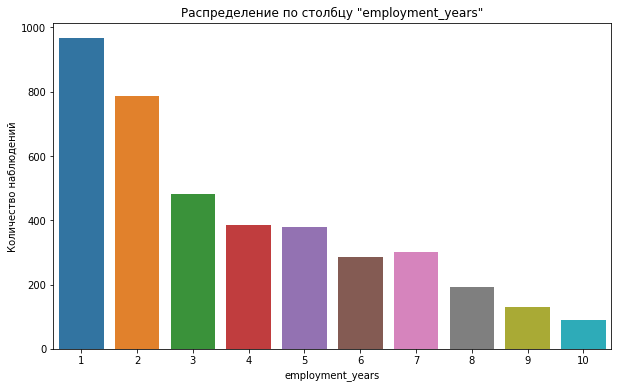

In [29]:
# df_train_job
countplot_(df_train_job, 'employment_years')

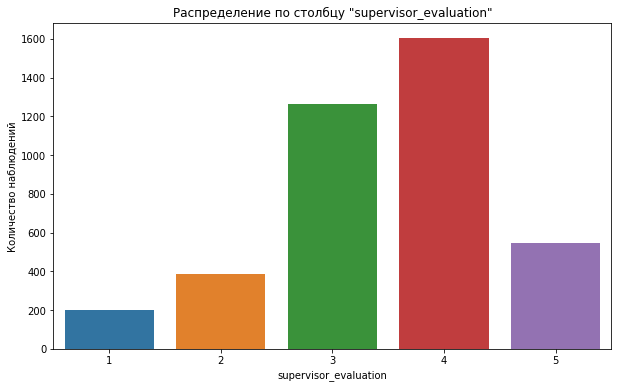

In [30]:
countplot_(df_train_job, 'supervisor_evaluation')

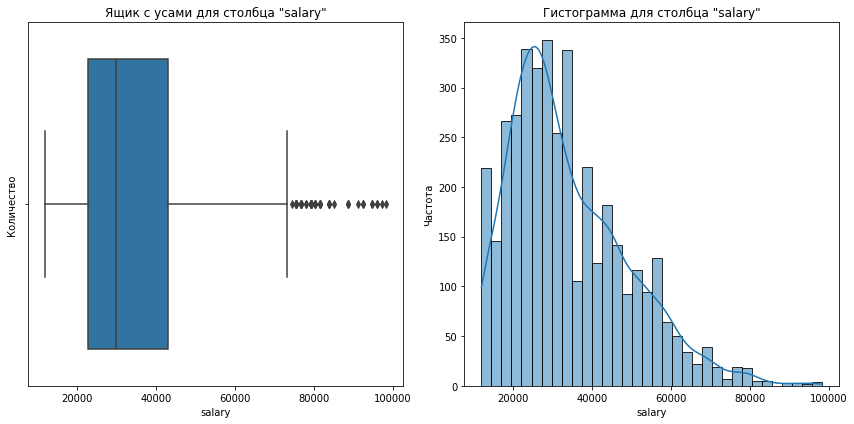

In [31]:
boxplot_(df_train_job, 'salary')

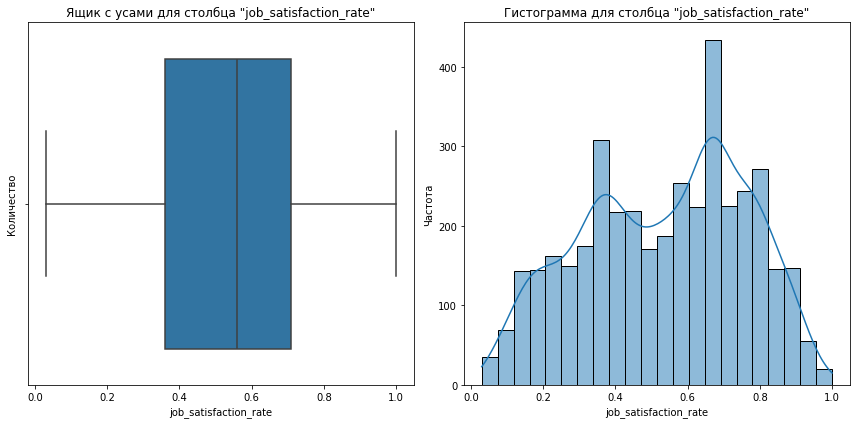

In [32]:
boxplot_(df_train_job, 'job_satisfaction_rate')

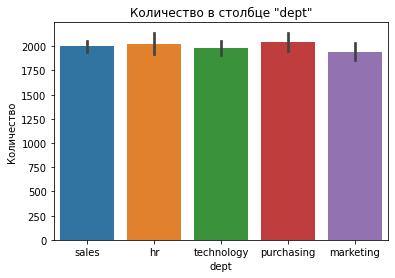

In [33]:
barplot_(df_train_job, 'dept', 0)

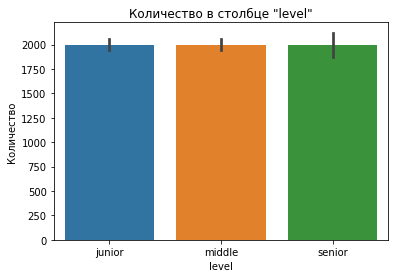

In [34]:
barplot_(df_train_job, 'level', 0)

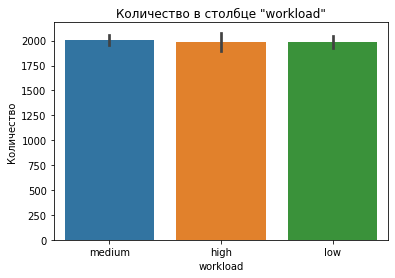

In [35]:
barplot_(df_train_job, 'workload', 0)

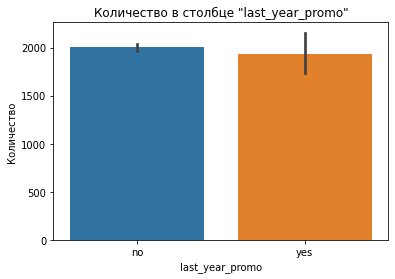

In [36]:
barplot_(df_train_job, 'last_year_promo', 0)

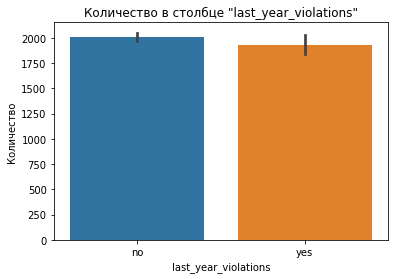

In [37]:
barplot_(df_train_job, 'last_year_violations', 0)

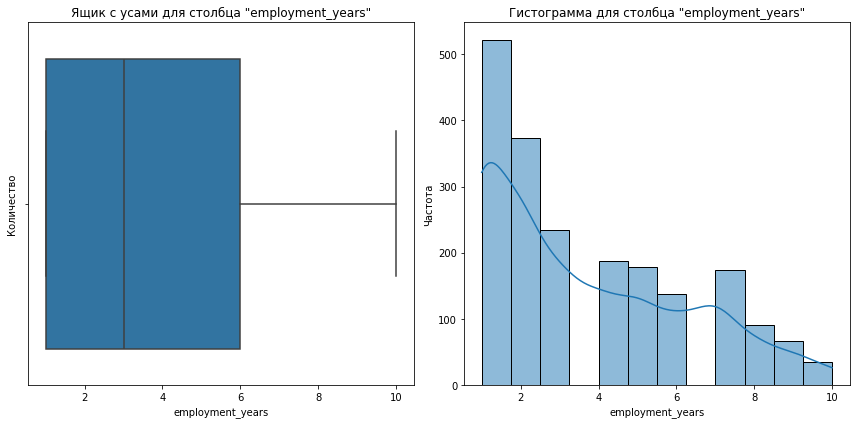

In [38]:
# df_test_features
boxplot_(df_test_features, 'employment_years')

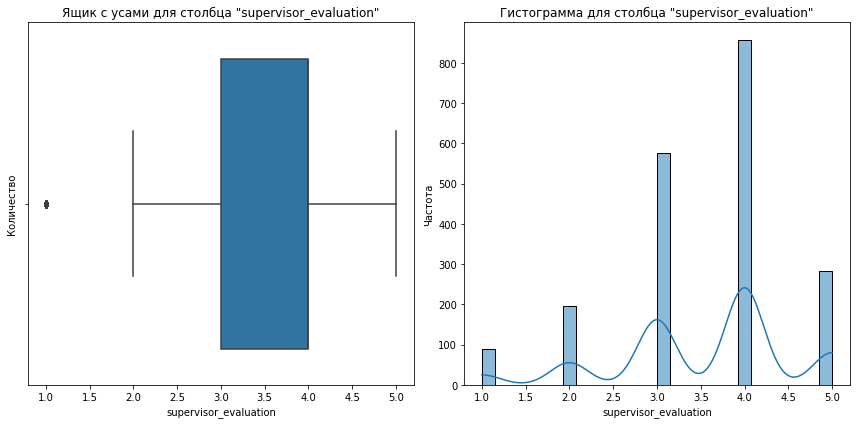

In [39]:
boxplot_(df_test_features, 'supervisor_evaluation')

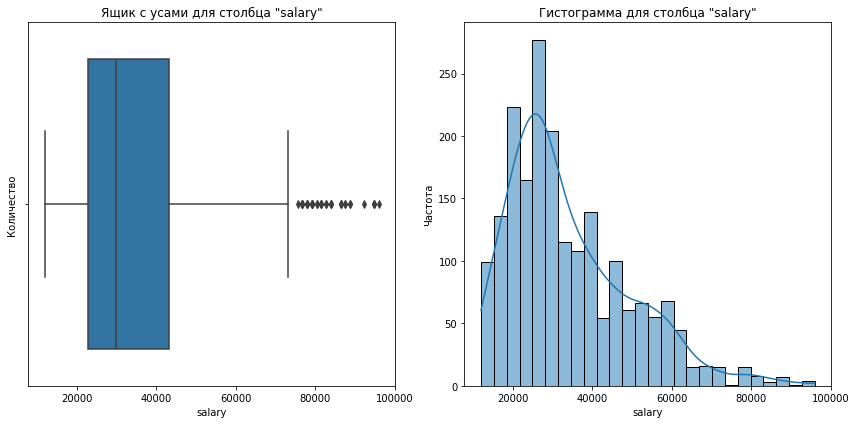

In [40]:
boxplot_(df_test_features, 'salary')

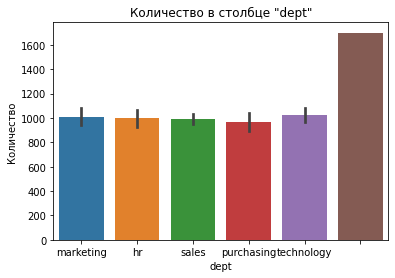

In [41]:
barplot_(df_test_features, 'dept', 0)

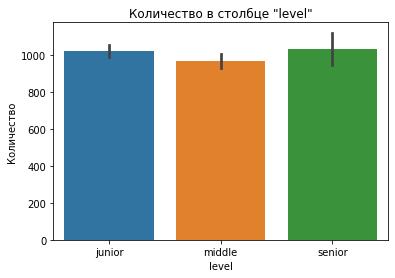

In [42]:
barplot_(df_test_features, 'level', 0)

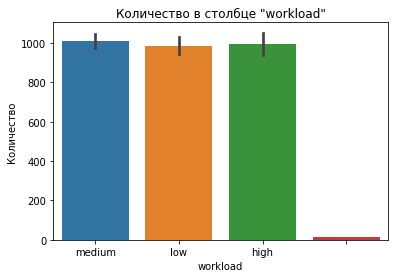

In [43]:
barplot_(df_test_features, 'workload', 0)

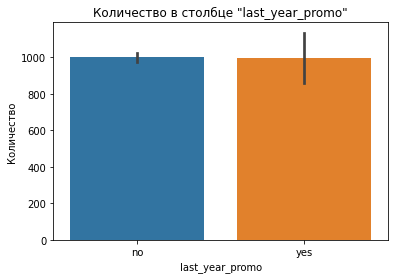

In [44]:
barplot_(df_test_features, 'last_year_promo', 0)

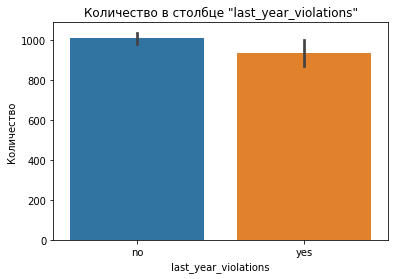

In [45]:
barplot_(df_test_features, 'last_year_violations', 0)

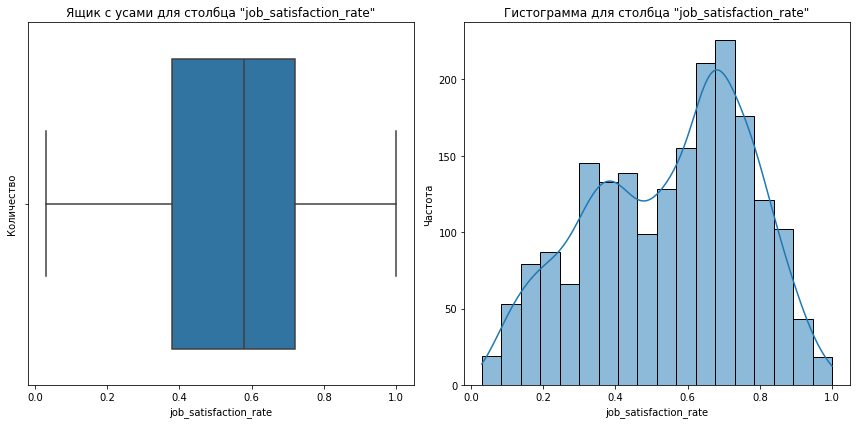

In [46]:
# df_test_target_job
boxplot_(df_test_target_job, 'job_satisfaction_rate')

Теперь выполним анализ корреляции с помощью матрицы корреляции phik.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 4000. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


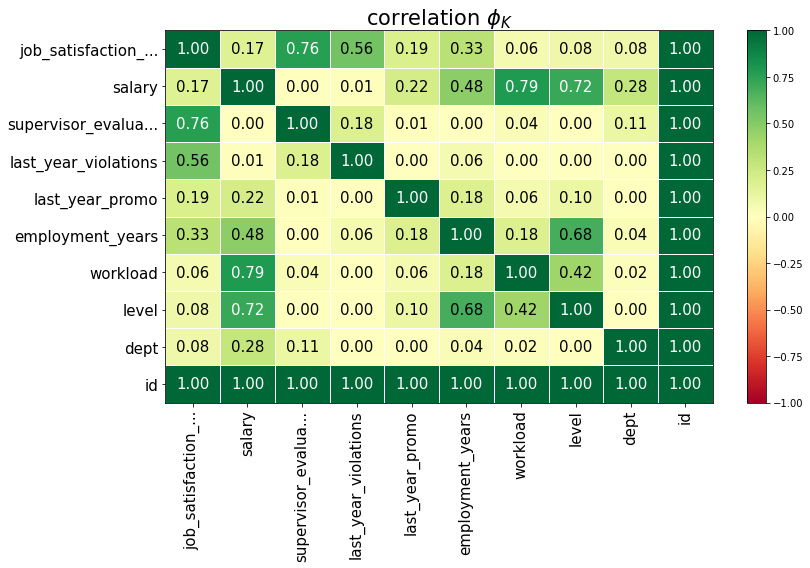

In [47]:
# df_train_job
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = df_train_job.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)
None

Чтобы провести корреляционный анализ для тестовой выборки, необходимо объединить ее для этих целей с целевый признаком.

In [48]:
merge_test = pd.merge(df_test_features, df_test_target_job, on = 'id', how='inner')

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 2000. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


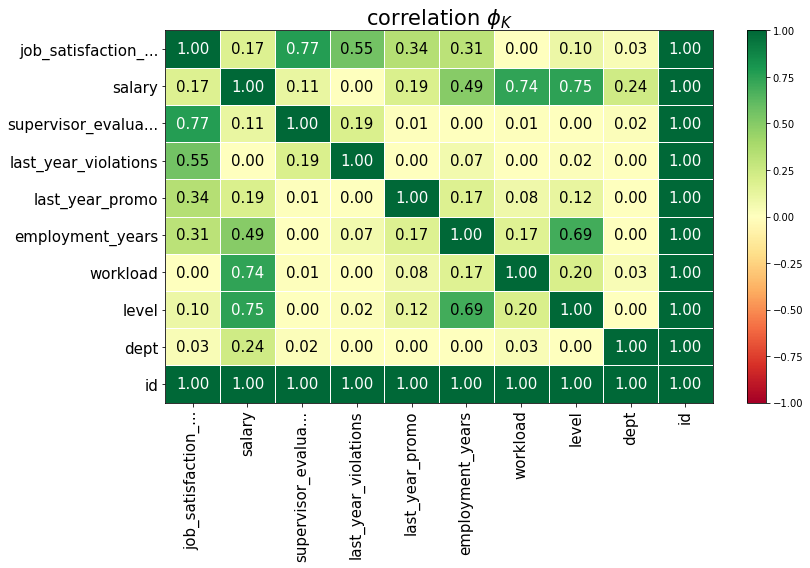

In [49]:
# merge_test
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = merge_test.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)
None

**Промежуточный вывод:**<br>Графики выглядят нормально, ничего особенного не обнаружено. Имеются выбросы по столбцу "salary", однако это нормально, ведь уровень зарплаты у всех разный.<br>По матрицам корреляции стоит сказать, что из зависимостей выделяется: зависимость между "job_satisfaction_rate" и "supervisor_evaluation", между "job_satisfaction_rate" и "last_year_violations".

# Подготовка данных.

Первое, что мы сделаем - это сохарним датасеты с id, если вдруг в будущем понадобится что-то с чем-то объединять. В подготовке данных и обучении модели id будет лишь мешать нам, поэтому эти шаги мы будем делать уже без него.

In [50]:
# сохраняем датасеты с id 
train_job_id = df_train_job.copy()
test_job_id = df_test_features.copy()
test_target_job_id = df_test_target_job.copy()

In [51]:
df_train_job = df_train_job.drop('id', axis = 1)
merge_test = merge_test.drop('id', axis = 1)

Теперь необходимо проверить данные в тренировачном датасете на явные дубликаты.

In [52]:
df_train_job.duplicated().sum()

245

In [53]:
df_train_job = df_train_job.drop_duplicates().reset_index(drop = True)

In [54]:
RANDOM_STATE = 42
y_train = df_train_job['job_satisfaction_rate']
X_train = df_train_job.drop('job_satisfaction_rate', axis = 1)

y_test = merge_test['job_satisfaction_rate']
X_test = merge_test.drop('job_satisfaction_rate', axis = 1)

In [55]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation'] 

In [56]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ohe_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))#drop='first'
    ])

In [57]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_ord_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ord_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                ))
    ]
)

In [58]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [59]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept'...
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years', 'salary',
                                                   'supervisor_evaluation'])])),
                ('models', DecisionTreeRegressor(random_state=42))])

**Промежуточный вывод:**<br>Мы выполнили подготовку признаков в пайплайне, учитывая особенности признаков и моделей и использовав два кодировщика.

# Обучение моделей.

In [60]:
def smape_metric(y_test, y_pred):
    n = len(y_test)
    numerator = 2 * np.abs(y_pred - y_test)
    denominator = np.abs(y_test) + np.abs(y_pred)
    smape_values = numerator / denominator
    mean_smape = 100 / n * np.sum(smape_values)
    return mean_smape

In [61]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 12),
        'models__max_features': range(1, 12),
        'models__min_samples_leaf': range(1, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [LinearRegression()],
        'models__normalize': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [62]:
smape_scorer = make_scorer(smape_metric, greater_is_better=False)

In [63]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=27
)
random_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на валидационной выборке:', -random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                        

Выполним предсказание.

In [64]:
y_pred_1 = np.round(random_search.predict(X_test), 2)
print('Метрика лучшей модели на тестовой выборке:',smape_metric(y_test, y_pred_1))

Метрика лучшей модели на тестовой выборке: 14.70160709816


**Промежуточный вывод:**<br>Делаем вывод, что лучшей моделью оказалась: LinearRegression(). Далее мы выполнили предсказания и выяснсили, что метрика модели на тестовой выборке примерно равна 14.<br>Я считаю, что это отличные результаты.

# Оформление выводов.

Первая задача выполнена, а это значит, что время подвести некоторые итоги.<br>Сначала мы провели ознакомление с данными. Дубликатов и аномалий обнаружено не было.<br>Затем мы провели исследовательский анализ, в ходе которого убедились, что графики всех признаков выглядят нормально, из особенностей обнаружены лишь выбросы по столбцу "salary", однако это нормально, ведь уровень зарплаты у всех разный.<br>Далее мы сделали подготовку признаков в пайплайне, избавлись от пропусков.<br>После подготовки данных мы обучили модели DecisionTreeRegressor() и LinearRegression(). Лучшей из них оказалась DecisionTreeRegressor(max_depth=10, max_features=8, min_samples_leaf=4, random_state=42).<br>Стоит сказать, что мы выполнили нашу первую задачу, а именно - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

# Задача 2.

# Загрузка данных.

In [65]:
df_train_quit = pd.read_csv('/datasets/train_quit.csv')

In [66]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [67]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [68]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [69]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [70]:
df_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [71]:
df_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [72]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Промежуточный вывод:**<br>По первому взгляду все в норме, однако, если вскроются какие-либо проблемы, то будем решать по мере их поступления в следующих шагах.

# Предобработка данных.

**Работа с явными и неявными дубликатами.**

In [73]:
# df_train_quit
df_train_quit.duplicated().sum()

0

In [74]:
print(df_train_quit['dept'].unique())
print(df_train_quit['level'].unique())
print(df_train_quit['workload'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']


In [75]:
df_train_quit['level'] = df_train_quit['level'].replace('sinior', 'senior')

In [76]:
print(df_train_quit['level'].unique())

['middle' 'junior' 'senior']


In [77]:
# df_test_target_quit
df_test_target_quit.duplicated().sum()

0

In [78]:
print(df_test_target_quit['quit'].unique())

['yes' 'no']


**Работа с аномалиями.**

In [79]:
# df_train_quit
df_train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [80]:
# df_test_target_quit
df_test_target_quit.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


**Промежуточный вывод:**<br>В ходе данного шага ни  пропущенных значений, ни дубликатов, ни аномалий не было обнаружено.

# Исследовательский анализ данных.

Проведем базовый анализ данных, как и в прошлой задаче. Для чиловых признаков будем строить ящики с усами  и гистограммы, а для категориальных - столбчатые диаграммы. Для датасета df_test_features мы уже делали анализ, поэтому в данной задаче и на данном шаге не будем его затрагивать.

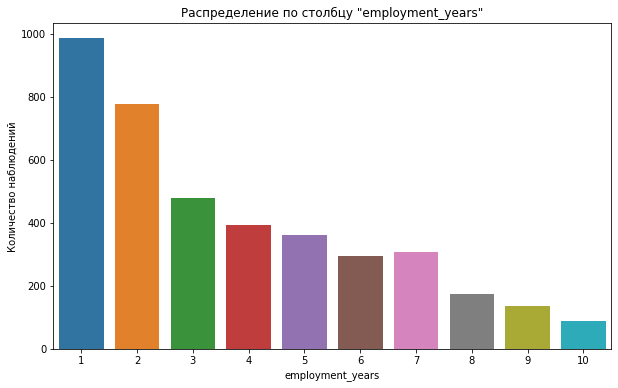

In [81]:
# df_train_quit
countplot_(df_train_quit, 'employment_years')

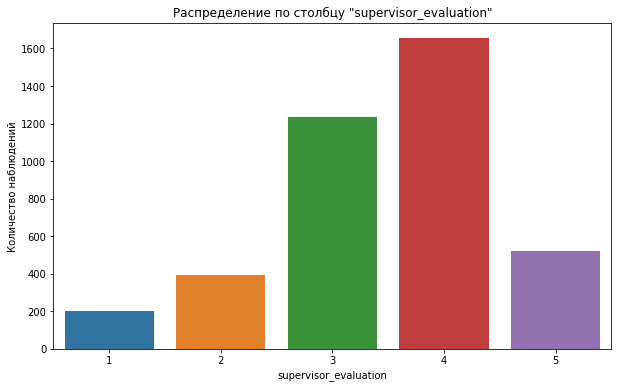

In [82]:
countplot_(df_train_quit, 'supervisor_evaluation')

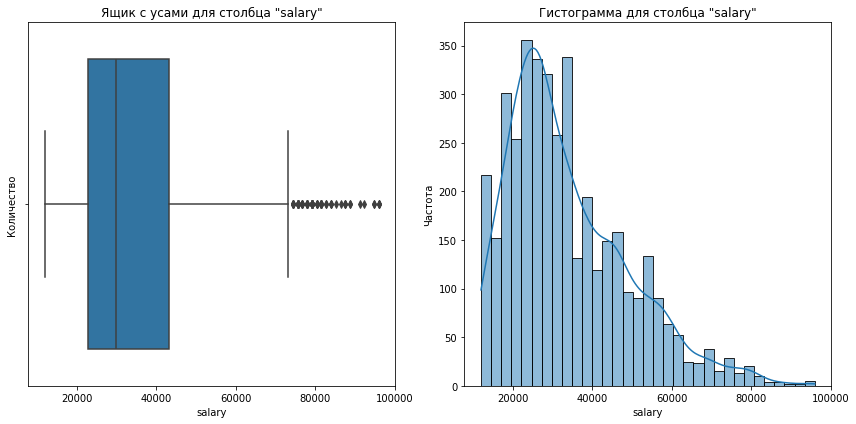

In [83]:
boxplot_(df_train_quit, 'salary')

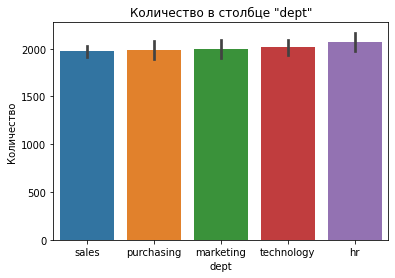

In [84]:
barplot_(df_train_quit, 'dept', 0)

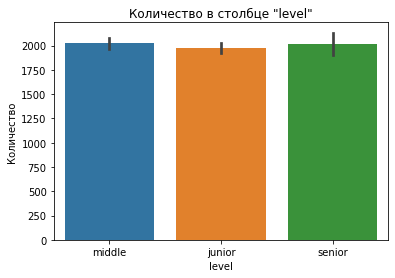

In [85]:
barplot_(df_train_quit, 'level', 0)

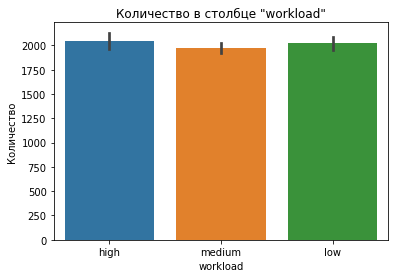

In [86]:
barplot_(df_train_quit, 'workload', 0)

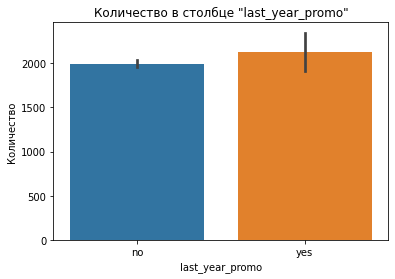

In [87]:
barplot_(df_train_quit, 'last_year_promo', 0)

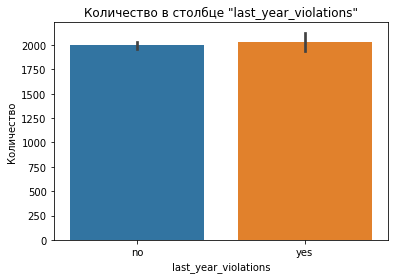

In [88]:
barplot_(df_train_quit, 'last_year_violations', 0)

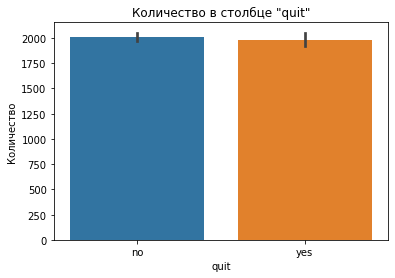

In [89]:
barplot_(df_train_quit, 'quit', 0)

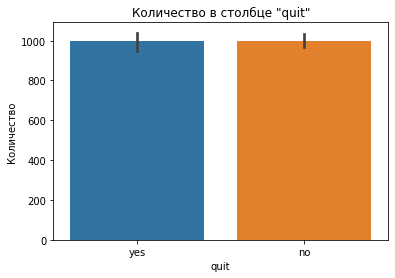

In [90]:
# df_test_target_quit
barplot_(df_test_target_quit, 'quit', 0)

Сразу стоит отметить, что по графикам все отлично, выбросов и проявления аномалий не наблдюдается, за исключением "salary" - много выбросов из-за разного уровня зарплаты сотрудников.<br>Теперь постараемся составить портрет уволившегося сотрудника. Для этого мы будем использовать столбчатые диаграммы, которые будут немного отличатся от тех, что были выше.

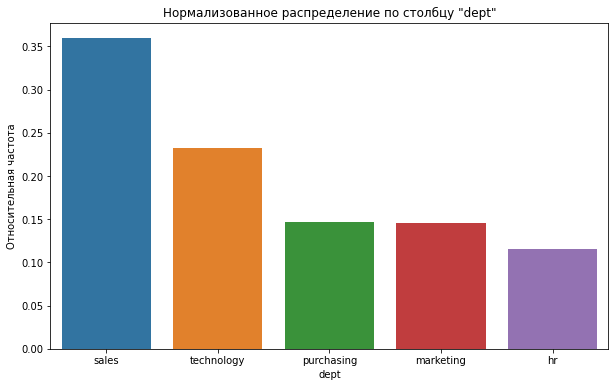

In [117]:
def countplot_2(x, normalize=False):
    plt.figure(figsize=(10, 6))

    if normalize:
        normalized_counts = df_train_quit[x].value_counts(normalize=True).reset_index()
        sns.barplot(x='index', y=x, data=normalized_counts)
        plt.title(f'Нормализованное распределение по столбцу "{x}"')
        plt.ylabel('Относительная частота')
        plt.xlabel(f'{x}')
    else:
        sns.countplot(x=x, data=df_train_quit)
        plt.title(f'Распределение по столбцу "{x}"')
        plt.ylabel('Количество наблюдений')
        plt.xlabel(f'{x}')

    plt.show()

countplot_2('dept', normalize=True)

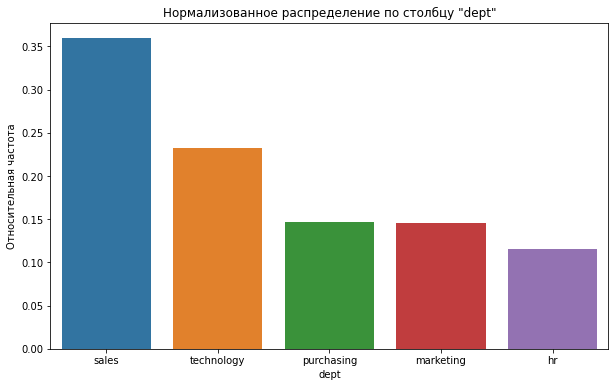

In [118]:
countplot_2('dept', True)

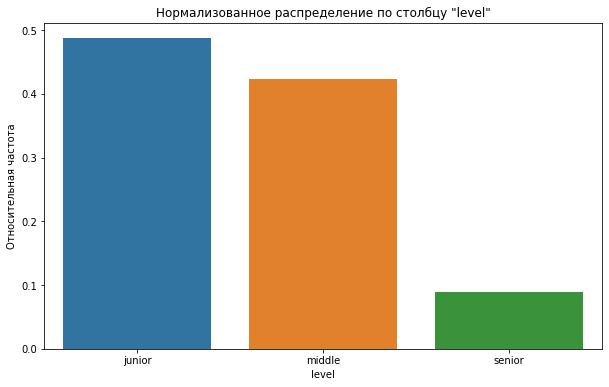

In [119]:
countplot_2('level', True)

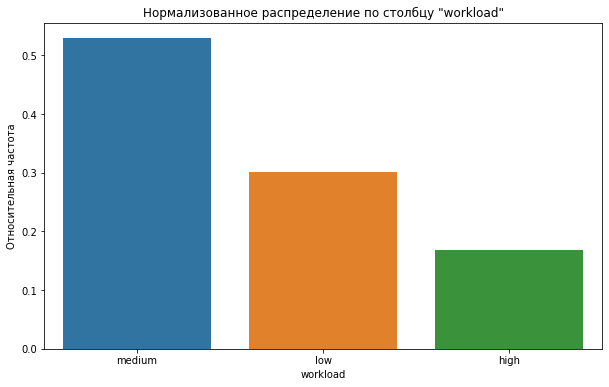

In [120]:
countplot_2('workload', True)

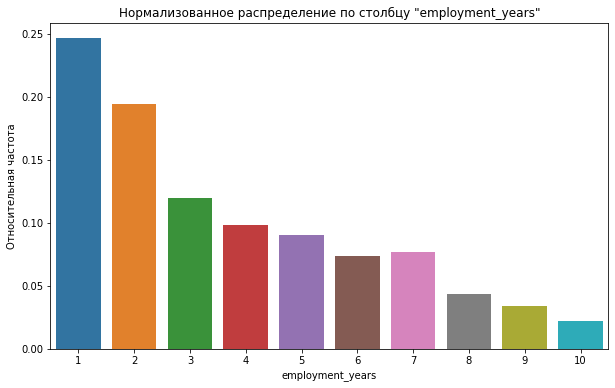

In [121]:
countplot_2('employment_years', True)

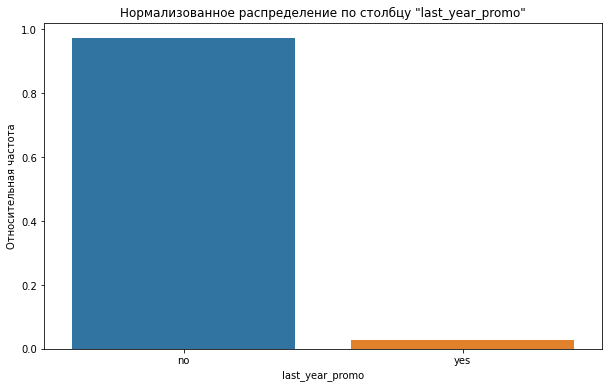

In [122]:
countplot_2('last_year_promo', True)

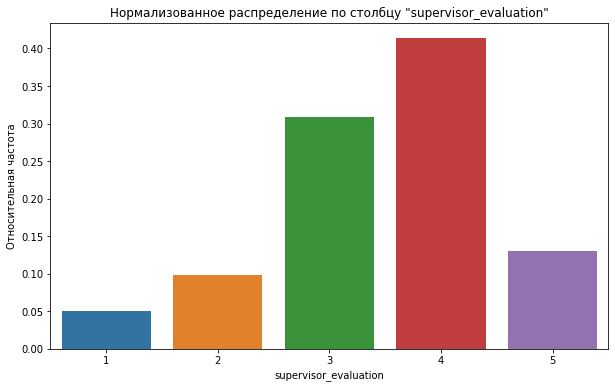

In [123]:
countplot_2('supervisor_evaluation', True)

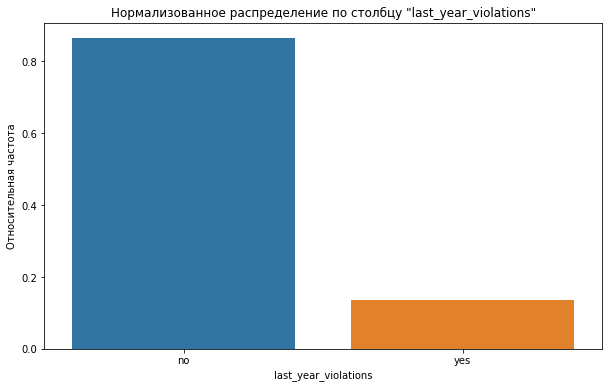

In [124]:
countplot_2('last_year_violations', normalize = True)

In [125]:
#countplot_2('salary')
print(df_train_quit.groupby('quit')['salary'].mean())

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64


Отсюда стоит сказать, что, если брать общую картину, то портрет «уволившегося сотрудника» выглядит примерно следующим образом:<br>сотрудник отдела продаж, по званию "junior", средней/высокой нагрузки, опыт работы в компании равен одному году, с повышением за последний год, оценка качества равна трем, без нарушений договора.<br>Так показали графики. А если говорить простыми словами, то увольняются, в большинстве, сотрудники, которые были на стажировке, перешли в штат на самое низкое звание, отработали год для опыта и ушли в другую компанию.

Теперь попробуем визуализировать и сравнить распределения признака "job_satisfaction_rate" для ушедших и оставшихся сотрудников.<br>А сделаем мы это с помощью ящиков с усами и гистограммам.

In [100]:
merge_ = pd.merge(df_test_target_quit, df_test_target_job, on = 'id', how='inner')

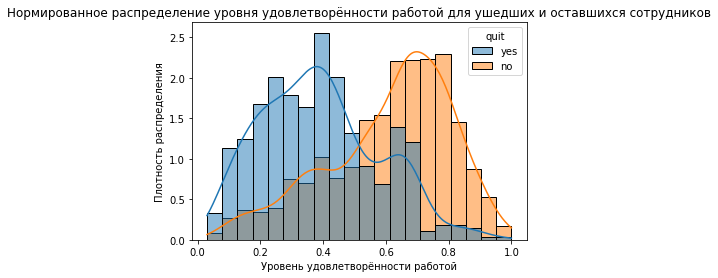

In [101]:
sns.histplot(data=merge_, x='job_satisfaction_rate', hue='quit', kde=True, bins=20, stat='density', common_norm=False)
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность распределения')
plt.title('Нормированное распределение уровня удовлетворённости работой для ушедших и оставшихся сотрудников')
plt.show()

Судя по графикам, можно сказать, что определенно зависимость есть. То есть, чем выше уровень удовлетворенности работой, тем меньше вероятность увольнения сотрудника.

**Промежуточный вывод:**<br>По графикам всех признаков все отлично, выбросов и проявления аномалий не наблюдается, за исключением "salary" - много выбросов из-за разного уровня зарплаты сотрудников.<br>Портрет уволившегося сотрудника: человек, который прошел стажировку, перешел в штат на самое низкое звание("junior"), отработал год для опыта и ушел в другую компанию.<br>Также мы выяснили, что уровень удовлетворенности работой и число уволившихся сотрудников однозначно связаны между собой: чем выше уровень удовлетворенности работой, тем меньше вероятность увольнения сотрудника.

# Добавление нового входного признака.

Прежде чем перейти к данному шагу, повторим действия с удалением id из датасетов и сохрании их с id в других переменных.

In [102]:
merge_test_2 = pd.merge(test_job_id, df_test_target_quit, on = 'id', how = 'inner')

In [103]:
train_quit_id = df_train_quit.copy()
test_quit_id = merge_test_2.copy()

df_train_quit = df_train_quit.drop('id', axis = 1)
merge_test_2 = merge_test_2.drop('id', axis = 1)

Добавим "job_satisfaction_rate", предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [104]:
# предсказания job_satisfaction_rate для df_test_features
merge_test_2['job_satisfaction_rate'] = y_pred_1
merge_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,no,0.83
1,hr,junior,medium,1,no,no,4,30000,no,0.67
2,sales,middle,low,5,no,no,4,19200,no,0.69
3,sales,middle,low,6,no,no,4,19200,no,0.69
4,hr,middle,medium,5,no,no,5,40800,no,0.81


In [105]:
df_train_quit_no = df_train_quit.drop('quit', axis = 1)

In [106]:
y_pred_ = np.round(random_search.predict(df_train_quit_no), 2)

In [107]:
# предсказания job_satisfaction_rate для df_train_quit
df_train_quit['job_satisfaction_rate'] = y_pred_
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,no,0.62
1,sales,junior,medium,2,no,no,4,27600,no,0.83
2,purchasing,middle,medium,5,no,no,1,37200,no,0.36
3,sales,junior,medium,2,no,yes,3,24000,yes,0.35
4,marketing,junior,medium,2,no,no,5,25200,no,0.83


**Промежуточный вывод:**<br>Мы добавили "job_satisfaction_rate", предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

# Подготовка данных.

In [108]:
y_train_2 = df_train_quit['quit']
X_train_2 = df_train_quit.drop('quit', axis = 1)

y_test_2 = merge_test_2['quit']
X_test_2 = merge_test_2.drop('quit', axis = 1)

In [109]:
ohe_columns_2 = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate'] 
#target_columns = ['quit']

In [110]:
ohe_pipe_2 = Pipeline(
        [
            ('simpleImputer_ohe_one',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('simpleImputer_ohe_two',SimpleImputer(missing_values=' ', strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
        ]
    )
ord_pipe_2 = Pipeline(
    [
        ('simpleImputer_ord_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ord_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                ))
    ]
)

In [111]:
# Кодируем целевой столбец с помощью LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_2)
y_test_encoded = label_encoder.transform(y_test_2)

data_preprocessor_2 = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe_2, ohe_columns_2),
        ('ord', ord_pipe_2, ord_columns_2),
        ('num', MinMaxScaler(), num_columns_2)
        #('target_encoder', LabelEncoder(), target_columns)
    ],
    remainder='passthrough'
)

In [112]:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

pipe_final_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept'...
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years', 'salary',
                                                   'supervisor_evaluation'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

**Промежуточный вывод:**<br>Мы выполнили подготовку признаков в пайплайне, учитывая особенности признаков и моделей и использовав два кодировщика.

# Обучение модели.

In [113]:
param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__min_samples_split': range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [114]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=27
)
randomized_search_2.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print('Метрика лучшей модели на валидационной выборке:', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                        

**Промежуточный вывод:**<br>Лучшей моделью во второй задаче оказалась: DecisionTreeClassifier(max_depth=5, min_samples_split=8,random_state=42))

In [115]:
y_pred_proba = randomized_search_2.predict_proba(X_test_2)[:, 1]
print('Метрика лучшей модели на тестовой выборке:', roc_auc_score(y_test_2, y_pred_proba))

Метрика лучшей модели на тестовой выборке: 0.9178130988364053


**Промежуточный вывод:**<br>Нужный результат метрики достигнут, а это значит, что можно переходить к выводам.

# Оформление выводов.

Со второй задачей мы также справились, а это значит, что стоит сделать некоторый вывод.<br>Сначала мы провели ознакомление с данными. Дубликатов и аномалий обнаружено не было. В ходе исследовательского анализа мы выяснили, что по графикам всех признаков все отлично, выбросов и проявления аномалий не наблюдается, за исключением "salary" - много выбросов из-за разного уровня зарплаты сотрудников.<br>Портрет уволившегося сотрудника: человек, который прошел стажировку, перешел в штат на самое низкое звание("junior"), отработал год для опыта и ушел в другую компанию.<br>Также мы выяснили, что уровень удовлетворенности работой и число уволившихся сотрудников однозначно связаны между собой: чем выше уровень удовлетворенности работой, тем меньше вероятность увольнения сотрудника.<br>Далее мы сделали подготовку признаков в пайплайне, избавлись от пропусков. После подготовки данных мы обучили модели DecisionTreeClassifier, SVC и LogisticRegression. Лучшей из них оказалась DecisionTreeClassifier(max_depth=5, min_samples_split=9,random_state=42)).<br>Стоит сказать, что мы выполнили и нашу вторую задачу, а именно - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Общий вывод.

Нами был подготовлен проект, состоящий из двух задач. Для каждой из них мы провели предобработку данных, исследовательский анализ данных(с визуализацией и промежуточными выводами), подготовку данных ()
<br><br>**Задача 1: Предсказание уровня удовлетворенности сотрудника**<br>Для первой задачи, связанной с предсказанием уровня удовлетворенности сотрудника, был использован алгоритм регрессии. В результате анализа данных, подготовки признаков и обучения моделей (DecisionTreeRegressor и LinearRegression), лучшей моделью оказалась DecisionTreeRegressor(max_depth=10, max_features=8, min_samples_leaf=4, random_state=42). Эта модель успешно предсказывает уровень удовлетворенности сотрудника на основе предоставленных данных.<br>**Выводы для бизнеса:**<br>С учетом предсказаний по уровню удовлетворенности сотрудников, компания может принимать меры для улучшения рабочей атмосферы и условий труда, что может снизить вероятность ухода сотрудников.<br>LinearRegression показала себя эффективной для данной задачи. Она может использоваться в режиме реального времени для оценки уровня удовлетворенности новых сотрудников или текущих сотрудников на основе изменяющихся данных.<br>**Задача 2: Предсказание увольнения сотрудника**<br>Для второй задачи, связанной с предсказанием увольнения сотрудника, был использован алгоритм классификации. В результате исследовательского анализа, подготовки данных и обучения моделей (DecisionTreeClassifier, SVC и LogisticRegression), лучшей моделью оказалась DecisionTreeClassifier(max_depth=5, min_samples_split=8,random_state=42).<br>**Выводы для бизнеса:**<br>Модель DecisionTreeClassifier может помочь компании предсказать вероятность увольнения сотрудника. Это позволяет принимать меры предосторожности и разрабатывать стратегии удержания сотрудников, что важно для устойчивости и успешного функционирования бизнеса.<br>Учесть важность факторов, влияющих на уход сотрудников, таких как стаж, звание, уровень удовлетворенности работой, может помочь компании оптимизировать свою кадровую политику и сделать рабочую среду более привлекательной для персонала.<br><br>Обе модели могут быть использованы в бизнесе для принятия стратегических решений и оптимизации управления персоналом.